In [ ]:
import os, cv2, random, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = "/content/drive/MyDrive/Waste_classification_dataset/DATASET/TRAIN"
test_path  = "/content/drive/MyDrive/Waste_classification_dataset/DATASET/TEST"

print("Train classes:", os.listdir(train_path))
print("Test classes:", os.listdir(test_path))

Train classes: ['O', 'R']
Test classes: ['R', 'O']


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.15, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest"
)
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_path,  target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False
)

Found 12174 images belonging to 2 classes.
Found 559 images belonging to 2 classes.


In [ ]:
print("Train class_indices:", train_generator.class_indices)
print("Test  class_indices:", test_generator.class_indices)
idx_to_class = {v:k for k,v in train_generator.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

Train class_indices: {'O': 0, 'R': 1}
Test  class_indices: {'O': 0, 'R': 1}


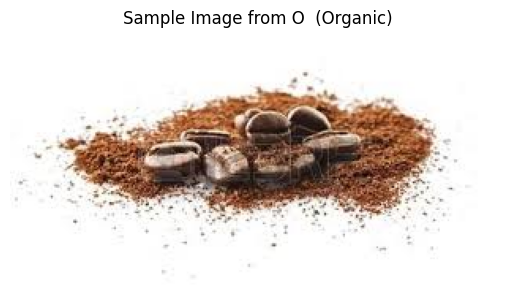

In [ ]:
# Path to "R" class folder
r_class_path = os.path.join(train_path, "O")

# Pick the first image inside R folder
r_img_path = os.path.join(r_class_path, os.listdir(r_class_path)[5])

# Load with cv2
img = cv2.imread(r_img_path)

# Convert BGR to RGB (for matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Sample Image from O  (Organic)")
plt.show()

In [ ]:
y_train = train_generator.classes  # integer labels
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {i:w for i,w in zip(classes, cw)}
print("Class weights:", class_weight)

Class weights: {np.int32(0): np.float64(0.5496162528216705), np.int32(1): np.float64(5.538671519563239)}


In [ ]:
base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in base.layers: layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(train_generator.num_classes, activation="softmax")(x)
model = Model(inputs=base.input, outputs=out)


In [ ]:
model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
ckpt = ModelCheckpoint("best_resnet_waste.keras", monitor="val_accuracy",
                       save_best_only=True, mode="max", verbose=1)
stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1)

In [ ]:
history1 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=6,
    class_weight=class_weight,
    callbacks=[ckpt, stop, plateau],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8929 - loss: 0.3506
Epoch 1: val_accuracy improved from -inf to 0.80859, saving model to best_resnet_waste.keras
381/381 ━━━━━━━━━━━━━━━━━━━━ 1023s 3s/step - accuracy: 0.8930 - loss: 0.3503 - val_accuracy: 0.8086 - val_loss: 0.6421 - learning_rate: 1.0000e-04
Epoch 2/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9548 - loss: 0.1183
Epoch 2: val_accuracy did not improve from 0.80859
381/381 ━━━━━━━━━━━━━━━━━━━━ 214s 495ms/step - accuracy: 0.9548 - loss: 0.1183 - val_accuracy: 0.7925 - val_loss: 0.6087 - learning_rate: 1.0000e-04
Epoch 3/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9595 - loss: 0.0984
Epoch 3: val_accuracy did not improve from 0.80859
381/381 ━━━━━━━━━━━━━━━━━━━━ 202s 495ms/step - accuracy: 0.9595 - loss: 0.0984 - val_accuracy: 0.7835 - val_loss: 0.7180 - learning_rate: 1.0000e-04
Epoch 4/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9670 - loss: 0.0969
Epoch 4: val_ac

In [ ]:
for layer in base.layers[-30:]: layer.trainable = True
model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
history2 = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=6,
    class_weight=class_weight,
    callbacks=[ckpt, stop, plateau],
    verbose=1
)

Epoch 1/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9477 - loss: 0.1165
Epoch 1: val_accuracy did not improve from 0.80859
381/381 ━━━━━━━━━━━━━━━━━━━━ 230s 553ms/step - accuracy: 0.9477 - loss: 0.1164 - val_accuracy: 0.7496 - val_loss: 0.7816 - learning_rate: 1.0000e-05
Epoch 2/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.9656 - loss: 0.0773
Epoch 2: val_accuracy did not improve from 0.80859
381/381 ━━━━━━━━━━━━━━━━━━━━ 193s 507ms/step - accuracy: 0.9656 - loss: 0.0773 - val_accuracy: 0.7657 - val_loss: 0.7720 - learning_rate: 1.0000e-05
Epoch 3/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.9773 - loss: 0.0585
Epoch 3: val_accuracy did not improve from 0.80859
381/381 ━━━━━━━━━━━━━━━━━━━━ 204s 513ms/step - accuracy: 0.9773 - loss: 0.0585 - val_accuracy: 0.7370 - val_loss: 0.8533 - learning_rate: 1.0000e-05
Epoch 4/6
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.9819 - loss: 0.0460
Epoch 4: val_accuracy did not improve from 0.80859



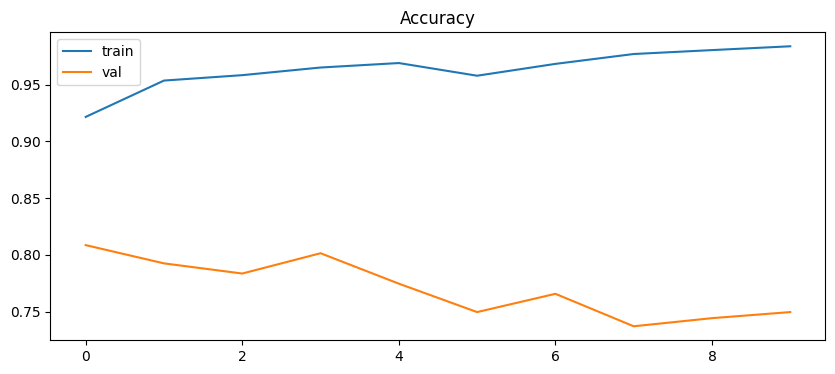

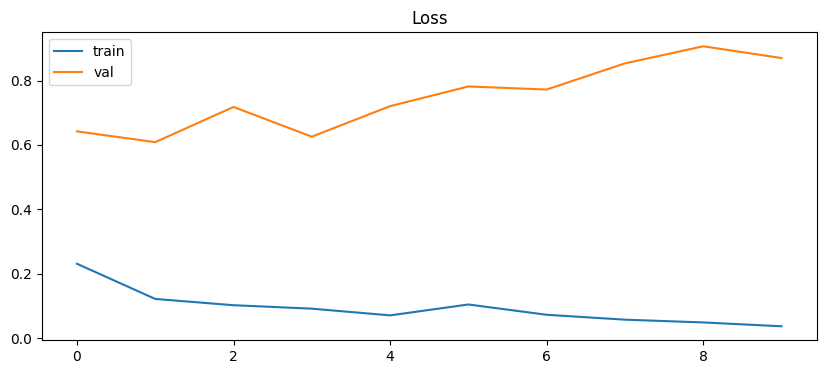

In [ ]:
def plot_curves(hists):
    acc = []; val_acc = []; loss = []; val_loss = []
    for h in hists:
        acc += h.history["accuracy"]; val_acc += h.history["val_accuracy"]
        loss += h.history["loss"];     val_loss += h.history["val_loss"]
    plt.figure(figsize=(10,4)); plt.plot(acc,label="train"); plt.plot(val_acc,label="val"); plt.title("Accuracy"); plt.legend(); plt.show()
    plt.figure(figsize=(10,4)); plt.plot(loss,label="train"); plt.plot(val_loss,label="val"); plt.title("Loss"); plt.legend(); plt.show()

plot_curves([history1, history2])

In [ ]:
def sample_indices_for_class(gen, class_name, n=3):
    class_id = train_generator.class_indices[class_name]
    idxs = [i for i,c in enumerate(gen.classes) if c == class_id]
    return random.sample(idxs, min(n, len(idxs)))

Check Organic:


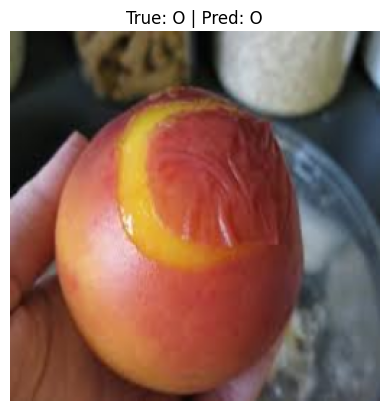

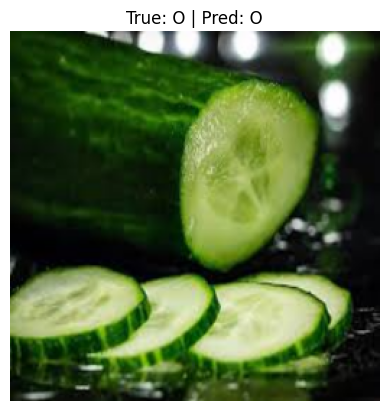

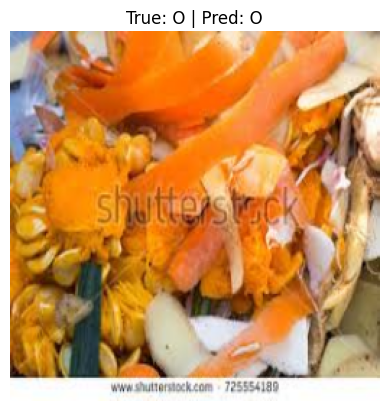

Check Recyclable:


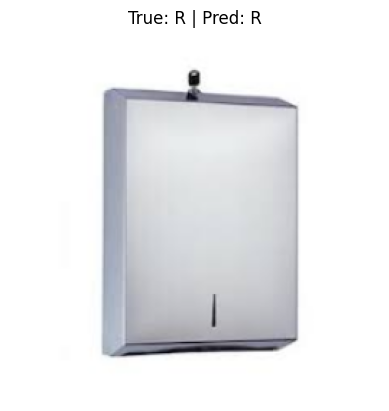

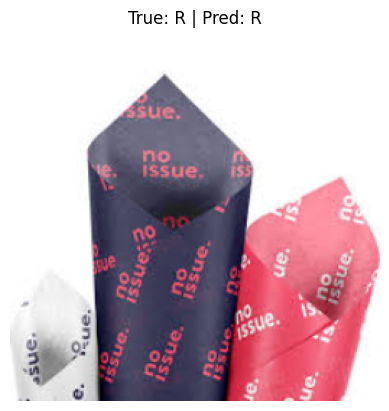

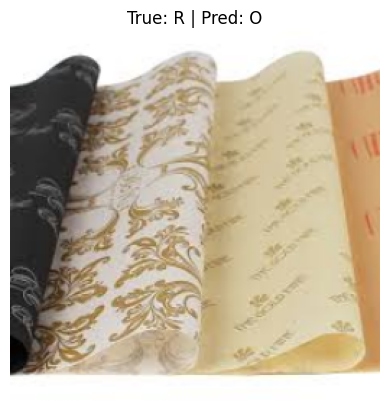

In [ ]:
def predict_random_from_class(class_name, n=3):
    idxs = sample_indices_for_class(test_generator, class_name, n)
    for i in idxs:
        img_path = test_generator.filepaths[i]
        img_bgr = cv2.imread(img_path)  # BGR for cv2
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        show = cv2.resize(img_rgb, (256,256))

        # IMPORTANT: same preprocessing as training
        x = cv2.resize(img_rgb, (224,224)).astype(np.float32)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        pred = model.predict(x, verbose=0)
        pred_idx = np.argmax(pred)
        pred_label = idx_to_class[pred_idx]

        plt.imshow(show); plt.axis("off")
        plt.title(f"True: {class_name} | Pred: {pred_label}")
        plt.show()

print("Check Organic:");     predict_random_from_class(class_names[0], n=3)  # usually 'O'
print("Check Recyclable:");  predict_random_from_class(class_names[1], n=3)  # usually 'R'

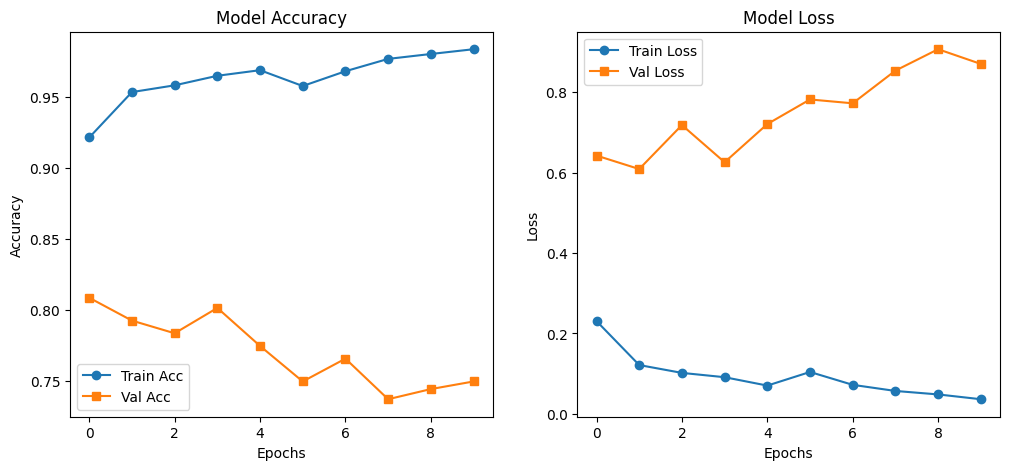

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


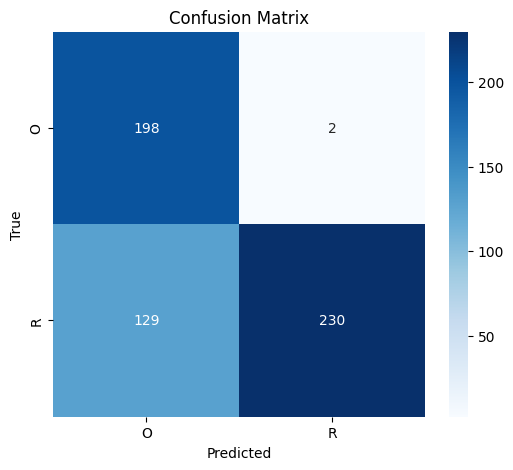

Classification Report:
               precision    recall  f1-score   support

           O       0.61      0.99      0.75       200
           R       0.99      0.64      0.78       359

    accuracy                           0.77       559
   macro avg       0.80      0.82      0.76       559
weighted avg       0.85      0.77      0.77       559



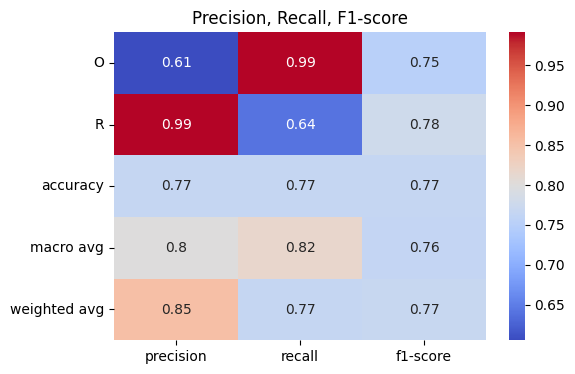

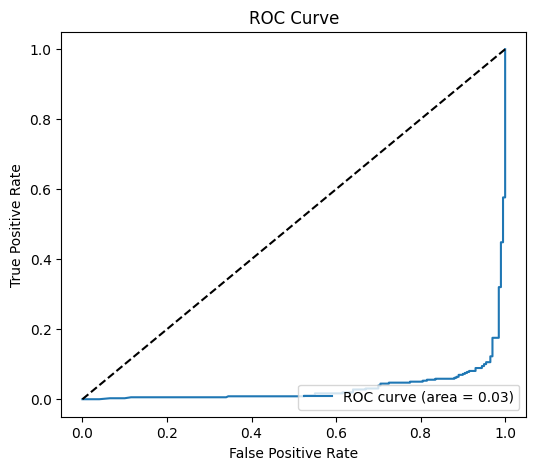

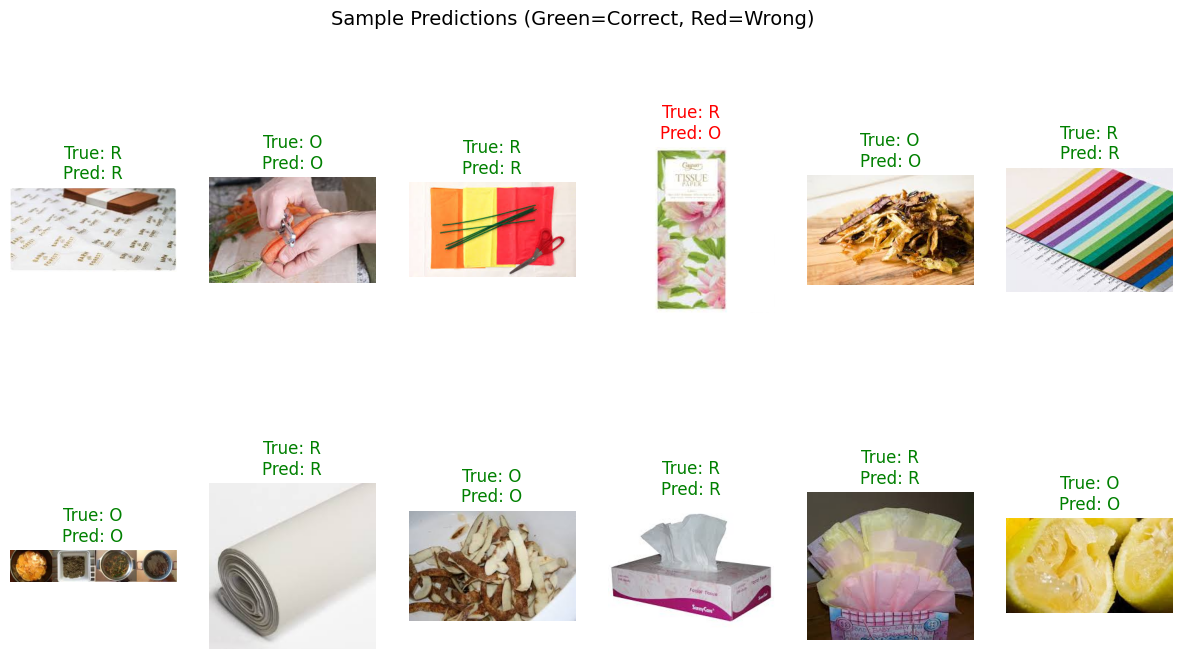

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Combine histories
full_history = {}
for key in history1.history.keys():
    full_history[key] = history1.history[key] + history2.history[key]

# ✅ Accuracy & Loss Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(full_history["accuracy"], label="Train Acc", marker="o")
plt.plot(full_history["val_accuracy"], label="Val Acc", marker="s")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(full_history["loss"], label="Train Loss", marker="o")
plt.plot(full_history["val_loss"], label="Val Loss", marker="s")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ✅ Predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# ✅ Confusion Matrix with percentages
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ✅ Classification Report (Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Plot Precision, Recall, F1 as Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap="coolwarm")
plt.title("Precision, Recall, F1-score")
plt.show()

# ✅ ROC Curve per class
y_true_bin = label_binarize(y_true, classes=[0,1])  # For binary classification
fpr, tpr, _ = roc_curve(y_true_bin[:,0], Y_pred[:,0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# ✅ Show Correct & Wrong Predictions
import random

def show_predictions(n=8):
    indices = random.sample(range(len(y_true)), n)
    plt.figure(figsize=(15,8))
    for i, idx in enumerate(indices):
        img_path = test_generator.filepaths[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = class_labels[y_true[idx]]
        pred_label = class_labels[y_pred[idx]]

        plt.subplot(2, n//2, i+1)
        plt.imshow(img_rgb)
        plt.axis("off")
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.suptitle("Sample Predictions (Green=Correct, Red=Wrong)", fontsize=14)
    plt.show()

# Show 12 predictions
show_predictions(12)